<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/gita_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bevezetés a gépi tanulási módszerek alkalmazásába

Workshop

Gita Műszaki Térinformatika Egyesület konferenciája, 2024. április 25-26, Esztergom, Szent Adalbert Rendezvény Központ

Összeállította: Siki Zoltán, Hrutka Bence

## Felügyelet nélküli módszerek

### Csoportképzés (klaszterezés) DBSCAN

A DBSCAN (density-based spatial clustering of applications with noise) algoritmus a pontok sűrűsége alapján előre nem ismert számú csoportot képes kialakítani. Két paramétert szükséges megadni,

- *eps* maximális távolság szomszédos pontok között
- *n_min* mag pontok minimális száma

![DBSCAN](https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/images/dbscan.png?raw=true)

#### Példa véletlenszámmal generált adatok alapján



Csoportok száma: 4
Zaj pontok száma: 90


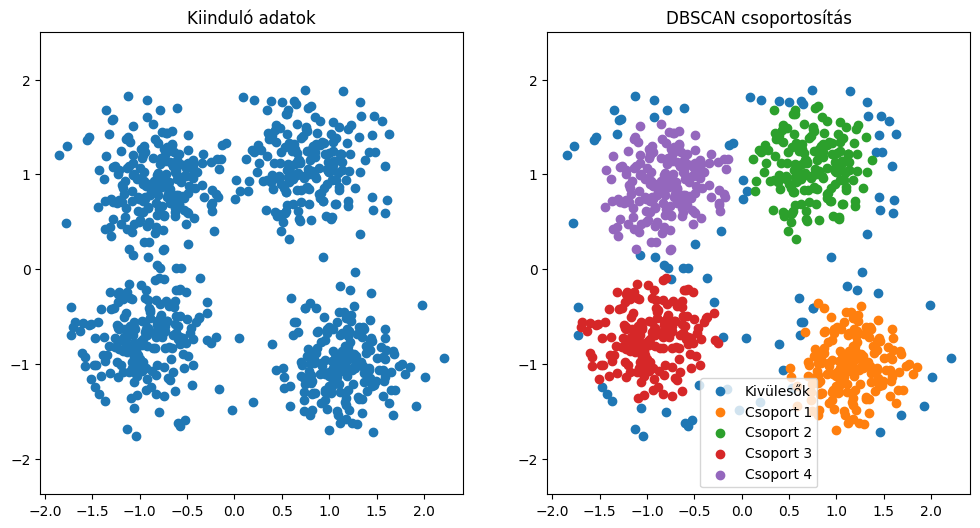

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from matplotlib import pyplot as plt
from numpy import unique, where

# minta adatok generálása
centers = [[0.8, 1.1], [-0.9, -0.7], [1.1, -1.0], [-0.8, 0.9]]
X, labels_true = make_blobs(
    n_samples=800, centers=centers, cluster_std=0.35, random_state=0)
#X = StandardScaler().fit_transform(X)
# csoportok összegyűjtése
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
labels = db.labels_

print(f"Csoportok száma: {len(set(labels))-1}")
print(f"Zaj pontok száma: {list(labels).count(-1)}")

# modell illesztés
y = db.fit_predict(X)
# csoportok ábrázolása
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
plt.axis('equal')
ax0.set_aspect('equal', adjustable="datalim")
ax0.scatter(X[:,0], X[:,1])
ax0.set_title("Kiinduló adatok")
ax1.set_aspect('equal', adjustable="datalim")
for cluster in unique(y):
	# csoporthoz tartozók kikeresése és ábrázolása
	row_ix = where(y == cluster)
	ax1.scatter(X[row_ix, 0], X[row_ix, 1], label= f"Csoport {cluster+1}" if cluster > -1 else "Kivülesők")
# show the plot
ax1.set_title('DBSCAN csoportosítás')
ax1.legend()

#### Példa pontfelhő pontjaira

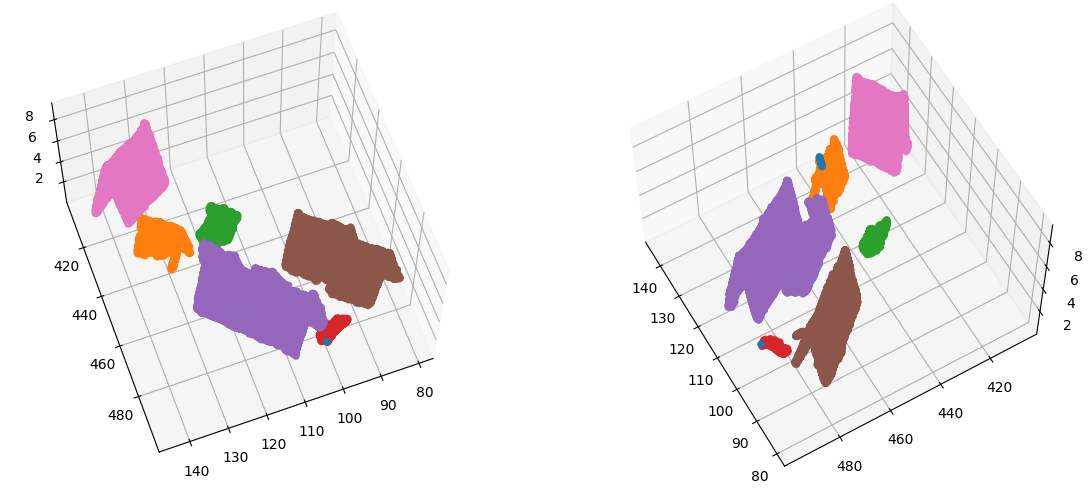

In [27]:
# minta adatok letöltése és kitömrítése
!rm -f barnag_roofs.*
!wget -q https://github.com/OSGeoLabBp/tutorials/raw/master/english/data_processing/lessons/code/barnag_roofs.zip
!unzip -q barnag_roofs.zip

from numpy import unique, where, asarray, loadtxt
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
# pontfelhő betöltése
xyz = np.loadtxt('barnag_roofs.xyz', dtype='float32', delimiter=' ')
# modell létrehozása
model = DBSCAN(eps=0.60, min_samples=100)
y = model.fit_predict(xyz)
# csoportok ábrázolása
fig = plt.figure(figsize=(14, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
for cluster in unique(y):
	# csoporthoz tartozók kikeresése és ábrázolása
	row_ix = where(y == cluster)
	ax0.scatter(xyz[row_ix, 0], xyz[row_ix, 1], xyz[row_ix, 2])
	ax1.scatter(xyz[row_ix, 0], xyz[row_ix, 1], xyz[row_ix, 2])
ax0.view_init(65, 70)
ax1.view_init(60, 150)